# Staffing Optimization: 24-Hour Operations Model
his model optimizes staffing across 6 distinct time blocks to minimize total headcount while meeting fluctuating demand. Each employee works a continuous 8-hour shift (covering two consecutive blocks).

| Shift Block | Shift Start | Shift End | Period Type      |
| ---------- | ----------- | --------- | ---------------- |
| 1          | 06.00       | 10.00     | Breakfast Rush   |                 
| 2          | 10.00       | 14.00     | Lunch Peak       |                 
| 3          | 14.00       | 18.00     | Afternoon Lull   |                 
| 4          | 18.00       | 22.00     | Dinner Rush      |                 
| 5          | 22.00       | 02.00     | Late Night Crowd | 
| 6          | 02.00       | 06.00     | Overnight / Prep | 

In [21]:
import pandas as pd

data_dir = '../data'

# ============================================
# 1. Load your data
# ============================================
demand_df = pd.read_excel(f'{data_dir}/demand.xlsx')
k_req = demand_df['Kitchen Req'].values
s_req = demand_df['Service Req'].values

demand_df

,Shift Block,Shift Start,Shift End,Period,Typical Activity,Kitchen Req,Service Req
0,1,06:00:00,10:00:00,6:00 AM – 10:00 AM,Breakfast Rush,8,4
1,2,10:00:00,14:00:00,10:00 AM – 2:00 PM,Lunch Peak,14,6
2,3,14:00:00,18:00:00,2:00 PM – 6:00 PM,Afternoon Lull,6,2
3,4,18:00:00,22:00:00,6:00 PM – 10:00 PM,Dinner Rush,14,4
4,5,22:00:00,02:00:00,10:00 PM – 2:00 AM,Late Night Crowd,7,4
5,6,02:00:00,06:00:00,2:00 AM – 6:00 AM,Overnight/Prep,4,2


In [22]:
# ============================================
# 2. Define the Linear Programming Problem
# ============================================
import pulp
prob = pulp.LpProblem("Optimal_Staffing", pulp.LpMinimize)

## The Sets and Variables (The Starting Times):

**Set(s):** 

set $T$ for shift block. 

**Decision Variables:**
Let $k_t$ and $s_t$ be integer decision variables representing staff starting at period $t$.
Example:
- $k_{1}$ : number of required kitchen staff at Shift Block 1 (06.00-10.00)
- $s_{2}$ : number of required kitchen staff at Shift Block 1 (10.00-14.00)


In [23]:
# ============================================
# 3. Define Decision Variables
# ============================================

# Define Variables for two different roles
# k = Kitchen Staff, s = Service Staff
periods = range(len(demand_df))
k_vars = pulp.LpVariable.dicts("Kitchen", periods, lowBound=0, cat='Integer')
s_vars = pulp.LpVariable.dicts("Service", periods, lowBound=0, cat='Integer')

## The Objective
Minimize the total number of people for both line (kitchen line and service line):
$$\text{Minimize } Z = \sum_{t \in T}k_t + \sum_{t \in T}s_t $$

In [24]:
# ============================================
# 4. Objective Function
# ============================================
# Minimize the sum of all people starting shifts

prob += pulp.lpSum(k_vars[t] + s_vars[t] for t in periods)

## The Overlapping Constraints
Because each person works 8 hours, the staff present in Period 2 is the sum of people who started in Period 1 and those who just started in Period 2.
- 6 AM – 10 AM: $k_6 + k_1 \geq 8$
- 10 AM – 2 PM: $k_1 + k_2 \geq 14$
- 2 PM – 6 PM: $k_2 + k_3 \geq 6$
- 6 PM – 10 PM: $k_3 + k_4 \geq 14$
- 10 PM – 2 AM: $k_4 + k_5 \geq 7$
- 2 AM – 6 AM: $k_5 + k_6 \geq 4$

In [25]:
# ============================================
# 5. Adding Constraints (The Overlap Logic)
# ============================================

# Each person works two consecutive periods. 
# Period t is covered by people starting in Period t AND Period t-1.

for t in periods:
    prob += k_vars[t] + k_vars[(t-1) % 6] >= k_req[t], f"K_Min_{t}"
    prob += s_vars[t] + s_vars[(t-1) % 6] >= s_req[t], f"S_Min_{t}"

In [26]:
# 6. Solve the problem
prob.solve(pulp.PULP_CBC_CMD(msg=0))

# 7. Print the Results
print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Grand Total Staff Needed: {pulp.value(prob.objective)}")
print("-" * 30)

# Calculate and print Kitchen results
total_k = sum(k_vars[i].varValue or 0 for i in range(6))
print(f"Minimum Kitchen Staff Needed: {total_k}")
for i in range(6):
    print(f"  > Kitchen starts at {demand_df['Period'].iloc[i]}: {int(k_vars[i].varValue)}")

print("-" * 30)

# Calculate and print Service results
total_s = sum(s_vars[i].varValue or 0 for i in range(6))
print(f"Minimum Service Staff Needed: {total_s}")
for i in range(6):
    print(f"  > Service starts at {demand_df['Period'].iloc[i]}: {int(s_vars[i].varValue)}")

Status: Optimal
Grand Total Staff Needed: 44.0
------------------------------
Minimum Kitchen Staff Needed: 32.0
  > Kitchen starts at 6:00 AM – 10:00 AM: 4
  > Kitchen starts at 10:00 AM – 2:00 PM: 10
  > Kitchen starts at 2:00 PM – 6:00 PM: 0
  > Kitchen starts at 6:00 PM – 10:00 PM: 14
  > Kitchen starts at 10:00 PM – 2:00 AM: 0
  > Kitchen starts at 2:00 AM – 6:00 AM: 4
------------------------------
Minimum Service Staff Needed: 12.0
  > Service starts at 6:00 AM – 10:00 AM: 4
  > Service starts at 10:00 AM – 2:00 PM: 2
  > Service starts at 2:00 PM – 6:00 PM: 0
  > Service starts at 6:00 PM – 10:00 PM: 4
  > Service starts at 10:00 PM – 2:00 AM: 0
  > Service starts at 2:00 AM – 6:00 AM: 2


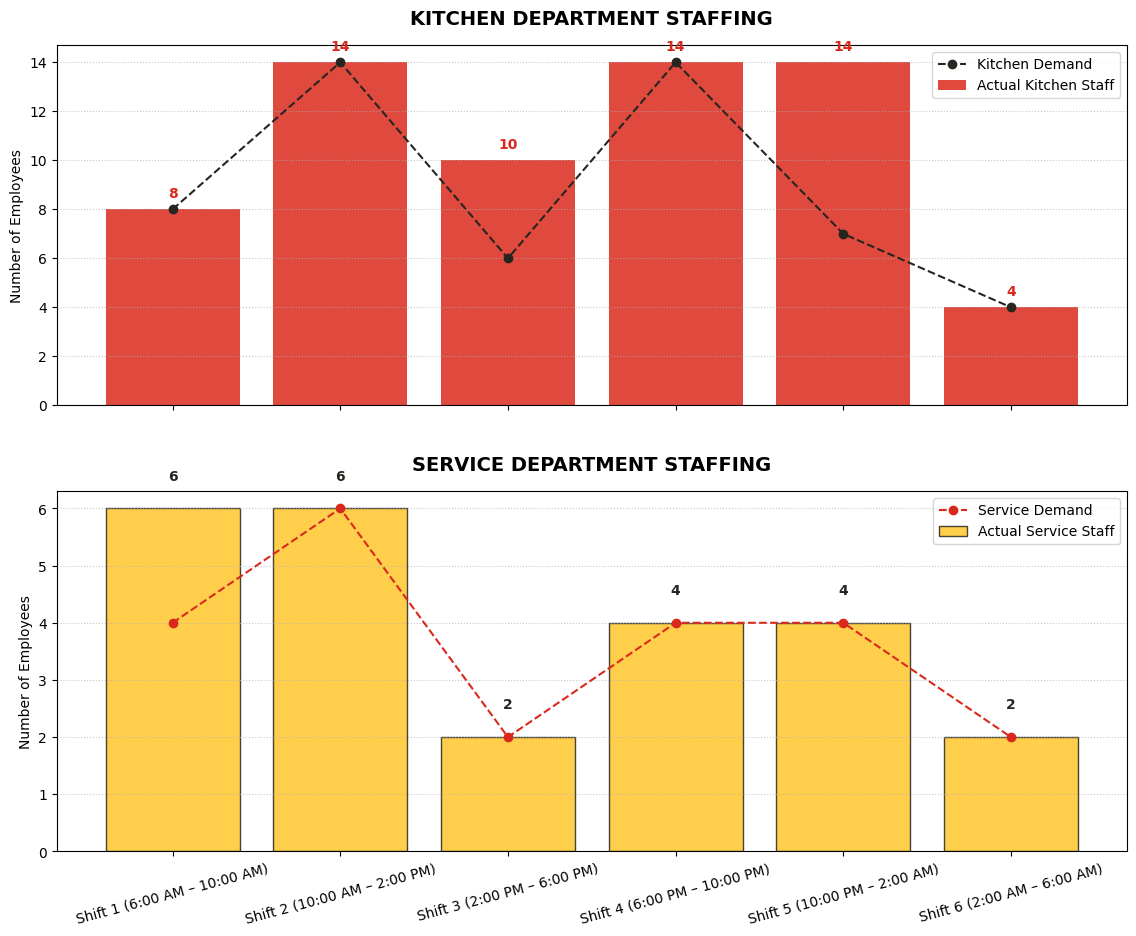

In [31]:
import matplotlib.pyplot as plt
import os

# 1. Setup
result_dir = '../result'

# Brand Colors
MCD_RED = '#DA291C'
MCD_YELLOW = '#FFC72C'
MCD_BLACK = '#27251F'

# Plotting with Subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
actual_k = [pulp.value(k_vars[i] + k_vars[(i-1)%6]) for i in range(6)]
actual_s = [pulp.value(s_vars[i] + s_vars[(i-1)%6]) for i in range(6)]


# --- Kitchen Subplot ---
ax1.bar(periods, actual_k, color=MCD_RED, label='Actual Kitchen Staff', alpha=0.85)
ax1.plot(periods, k_req, color=MCD_BLACK, linestyle='--', marker='o',label='Kitchen Demand')
ax1.set_title("KITCHEN DEPARTMENT STAFFING", fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel("Number of Employees")
ax1.grid(axis='y', linestyle=':', alpha=0.7)
ax1.legend(loc='upper right')

# Add labels on bars
for i, v in enumerate(actual_k):
    ax1.text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold', color=MCD_RED)

# --- Service Subplot ---
ax2.bar(periods, actual_s, color=MCD_YELLOW, label='Actual Service Staff', alpha=0.85, edgecolor=MCD_BLACK)
ax2.plot(periods, s_req, color=MCD_RED, linestyle='--', marker='o', label='Service Demand')
ax2.set_title("SERVICE DEPARTMENT STAFFING", fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel("Number of Employees")
ax2.grid(axis='y', linestyle=':', alpha=0.7)
ax2.legend(loc='upper right')

# Add labels on bars
for i, v in enumerate(actual_s):
    ax2.text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold', color=MCD_BLACK)

# 4. Final Touches
plt.xticks(range(6), [f"Shift {i+1} ({demand_df['Period'].iloc[i]})" for i in range(6)])
plt.xticks(rotation=15)
plt.tight_layout(pad=3.0) # Prevents overlap
plt.savefig(f'{result_dir}/multi_role_staffing.png', dpi=300)
plt.show()

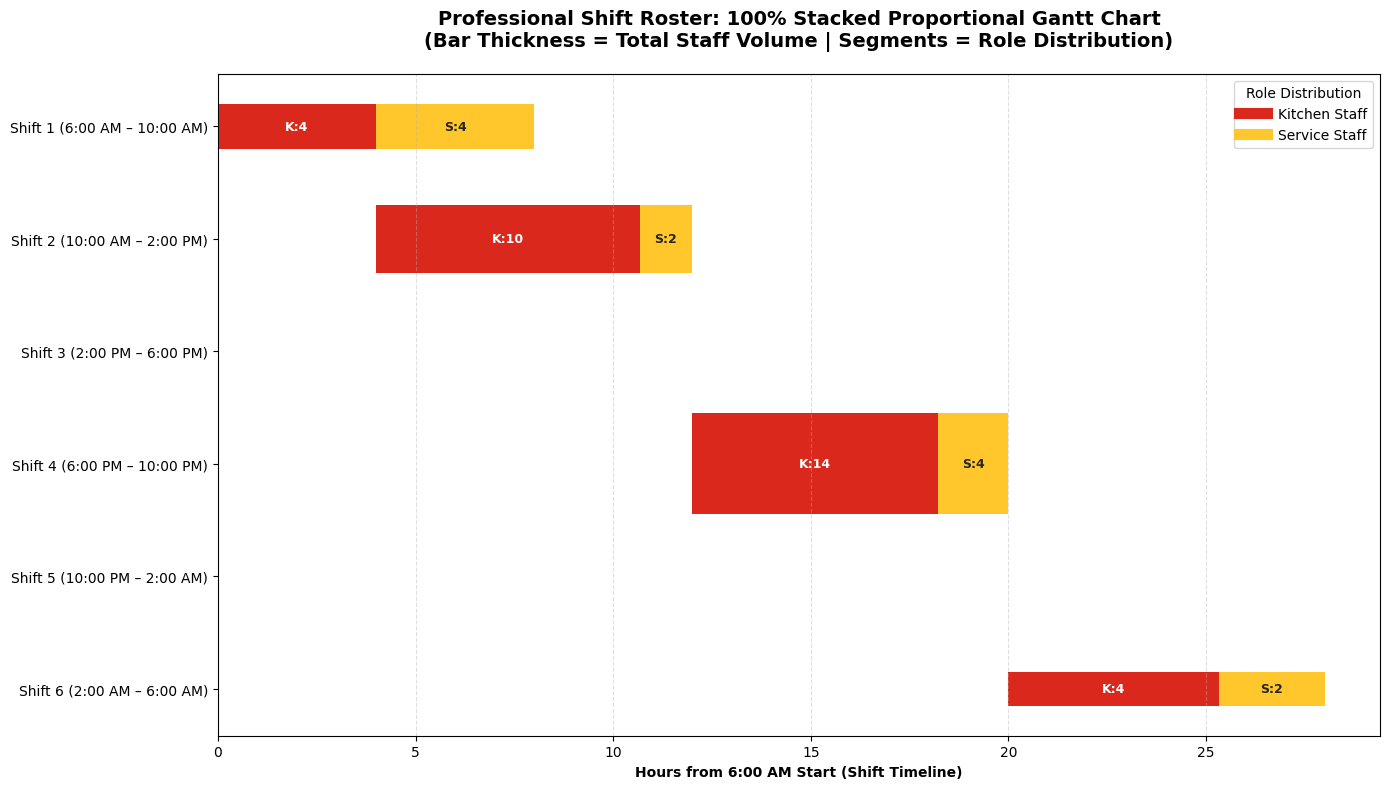

In [28]:
from matplotlib.lines import Line2D

# Data Preparation
# Fetching variable values (using 'or 0' to handle potential None values)
start_k = [k_vars[i].varValue or 0 for i in range(6)]
start_s = [s_vars[i].varValue or 0 for i in range(6)]
total_starts = [k + s for k, s in zip(start_k, start_s)]

plt.figure(figsize=(14, 8))
plt.style.use('default')

for i in range(6):
    start_time = i * 4  # Each period starts 4 hours apart
    duration = 8        # Standard shift duration
    
    # Calculate proportional bar thickness based on TOTAL staff starting
    # Adjust the divisor (20) to change the visual scaling of the bars
    total_thickness = max(0.1, total_starts[i] / 20) 
    
    # Calculate segment widths for the 100% stacked horizontal logic
    if total_starts[i] > 0:
        pct_k = (start_k[i] / total_starts[i]) * duration
        pct_s = (start_s[i] / total_starts[i]) * duration
    else:
        pct_k, pct_s = 0, 0

    # Plot Kitchen Segment (Left side of the 8-hour block)
    if start_k[i] > 0:
        plt.barh(y=i, width=pct_k, left=start_time, height=total_thickness, 
                 color=MCD_RED, label='Kitchen' if i == 0 else "")
        # Kitchen Data Label
        plt.text(start_time + pct_k/2, i, f"K:{int(start_k[i])}", 
                 va='center', ha='center', color='white', fontweight='bold', fontsize=9)

    # Plot Service Segment (Right side - Stacked horizontally)
    if start_s[i] > 0:
        plt.barh(y=i, width=pct_s, left=start_time + pct_k, height=total_thickness, 
                 color=MCD_YELLOW, label='Service' if i == 0 else "")
        # Service Data Label
        plt.text(start_time + pct_k + pct_s/2, i, f"S:{int(start_s[i])}", 
                 va='center', ha='center', color=MCD_BLACK, fontweight='bold', fontsize=9)

# 3. Aesthetics & Formatting
# Logic to handle different types of period formats safely
start_labels = []
for p in periods:
    if isinstance(p, str):
        label = p.split(' – ')[0] if ' – ' in p else p.split('-')[0]
        start_labels.append(label.strip())
    else:
        start_labels.append(str(p))
        
plt.yticks(range(6), [f"Shift {i+1} ({demand_df['Period'].iloc[i]})" for i in range(6)])
plt.xlabel('Hours from 6:00 AM Start (Shift Timeline)', fontweight='bold')
plt.title('Professional Shift Roster: 100% Stacked Proportional Gantt Chart\n' + 
          '(Bar Thickness = Total Staff Volume | Segments = Role Distribution)', 
          fontsize=14, fontweight='bold', pad=20)

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.gca().invert_yaxis()  # Ensures Shift 1 is at the top

# Professional Custom Legend
custom_lines = [Line2D([0], [0], color=MCD_RED, lw=8),
                Line2D([0], [0], color=MCD_YELLOW, lw=8)]
plt.legend(custom_lines, ['Kitchen Staff', 'Service Staff'], 
           loc='upper right', title="Role Distribution")

plt.tight_layout()
plt.savefig(f'{result_dir}/mcd_gantt_100pct_stacked.png', dpi=300)
plt.show()